In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import plot_model
import scipy.stats as stats
import os 
import h5py
import sys
import re
import xgboost as xgb 
import sklearn.multioutput

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
Y_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_eta', 'wl_phi', 'wl_pt']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  100000 

In [2]:
import scale_variables

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'divmax', 'eta':'meanmax', 'phi':'linear_sincos', 'DL1r':'meanmax', 'm':'divmax', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(X_keys, X_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 2.2737367544323206e-13


In [3]:
# Create X and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(X_total)
    np.random.set_state(rng_state)
    np.random.shuffle(Y_total)

trainX, testX = X_total[0:split, :], X_total[split:,:]
trainY, testY = Y_total[0:split,:], Y_total[split:,:]

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(80000, 44) (80000, 12)
(20000, 44) (20000, 12)


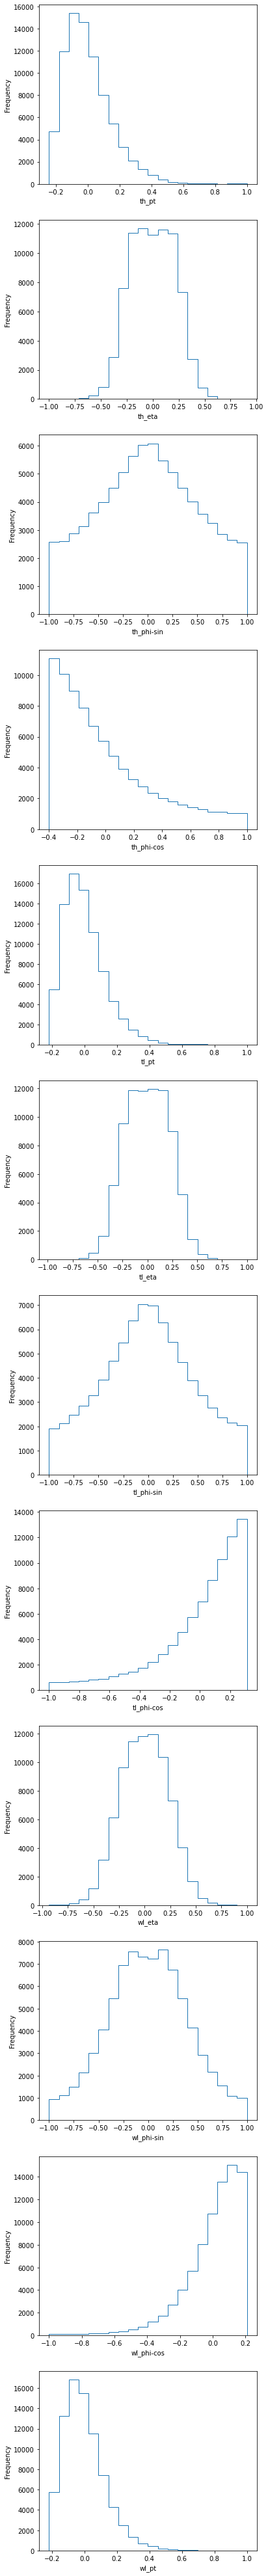

In [4]:
# Histograms of Y variables 
show = True

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        plt.hist(trainY[:,i], 20, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

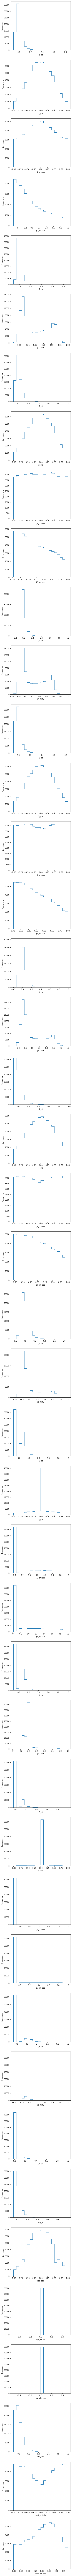

In [5]:
# Histograms of X variables 
show = True

if show:
    plt.figure(figsize=(6,6*trainX.shape[1]))
    for i in range(0, trainX.shape[1]):
        plt.subplot(trainX.shape[1], 1, i+1)
        plt.hist(trainX[:,i], 20, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [6]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(X_names)]),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(Y_names),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      X_shape=[len(X_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [7]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               23040     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1

In [8]:
# Fit model

Epochs= 2048

history = model.fit(trainX, trainY, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Train on 64000 samples, validate on 16000 samples
Epoch 1/2048
64000/64000 [==============================] - 2s 28us/sample - loss: 0.0964 - mse: 0.0884 - val_loss: 0.0946 - val_mse: 0.0866
Epoch 2/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0960 - mse: 0.0880 - val_loss: 0.0943 - val_mse: 0.0863
Epoch 3/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0957 - mse: 0.0877 - val_loss: 0.0939 - val_mse: 0.0859
Epoch 4/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0953 - mse: 0.0873 - val_loss: 0.0935 - val_mse: 0.0855
Epoch 5/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0949 - mse: 0.0869 - val_loss: 0.0931 - val_mse: 0.0851
Epoch 6/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0945 - mse: 0.0865 - val_loss: 0.0927 - val_mse: 0.0847
Epoch 7/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0940 - mse: 0.0860 

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0682 - mse: 0.0608 - val_loss: 0.0674 - val_mse: 0.0599
Epoch 59/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0681 - mse: 0.0607 - val_loss: 0.0672 - val_mse: 0.0598
Epoch 60/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0680 - mse: 0.0606 - val_loss: 0.0671 - val_mse: 0.0597
Epoch 61/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0678 - mse: 0.0604 - val_loss: 0.0670 - val_mse: 0.0596
Epoch 62/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0677 - mse: 0.0603 - val_loss: 0.0668 - val_mse: 0.0595
Epoch 63/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0676 - mse: 0.0602 - val_loss: 0.0667 - val_mse: 0.0594
Epoch 64/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0674 - mse: 0.0601 - val_loss: 0.0666 - val_mse: 0.0592
Epoch 65/2048
64000/

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0631 - mse: 0.0561 - val_loss: 0.0625 - val_mse: 0.0555
Epoch 116/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0630 - mse: 0.0560 - val_loss: 0.0625 - val_mse: 0.0555
Epoch 117/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0630 - mse: 0.0560 - val_loss: 0.0624 - val_mse: 0.0554
Epoch 118/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0629 - mse: 0.0559 - val_loss: 0.0624 - val_mse: 0.0554
Epoch 119/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0629 - mse: 0.0559 - val_loss: 0.0623 - val_mse: 0.0553
Epoch 120/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0628 - mse: 0.0558 - val_loss: 0.0623 - val_mse: 0.0553
Epoch 121/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0627 - mse: 0.0558 - val_loss: 0.0622 - val_mse: 0.0552
Epoch 122/2048

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0602 - mse: 0.0535 - val_loss: 0.0598 - val_mse: 0.0531
Epoch 173/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0601 - mse: 0.0535 - val_loss: 0.0598 - val_mse: 0.0531
Epoch 174/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0601 - mse: 0.0534 - val_loss: 0.0597 - val_mse: 0.0531
Epoch 175/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0600 - mse: 0.0534 - val_loss: 0.0597 - val_mse: 0.0530
Epoch 176/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0600 - mse: 0.0534 - val_loss: 0.0597 - val_mse: 0.0530
Epoch 177/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0600 - mse: 0.0533 - val_loss: 0.0596 - val_mse: 0.0530
Epoch 178/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0599 - mse: 0.0533 - val_loss: 0.0596 - val_mse: 0.0530
Epoch 179/2048
6

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0581 - mse: 0.0517 - val_loss: 0.0580 - val_mse: 0.0516
Epoch 230/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0581 - mse: 0.0517 - val_loss: 0.0580 - val_mse: 0.0516
Epoch 231/2048
64000/64000 [==============================] - 1s 11us/sample - loss: 0.0581 - mse: 0.0517 - val_loss: 0.0579 - val_mse: 0.0516
Epoch 232/2048
64000/64000 [==============================] - 1s 11us/sample - loss: 0.0581 - mse: 0.0517 - val_loss: 0.0579 - val_mse: 0.0515
Epoch 233/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0580 - mse: 0.0516 - val_loss: 0.0579 - val_mse: 0.0515
Epoch 234/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0580 - mse: 0.0516 - val_loss: 0.0579 - val_mse: 0.0515
Epoch 235/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0580 - mse: 0.0516 - val_loss: 0.0578 - val_mse: 0.0515
Epoch 236/2048

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0567 - mse: 0.0505 - val_loss: 0.0567 - val_mse: 0.0505
Epoch 287/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0566 - mse: 0.0505 - val_loss: 0.0567 - val_mse: 0.0505
Epoch 288/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0566 - mse: 0.0505 - val_loss: 0.0567 - val_mse: 0.0505
Epoch 289/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0566 - mse: 0.0504 - val_loss: 0.0566 - val_mse: 0.0505
Epoch 290/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0566 - mse: 0.0504 - val_loss: 0.0566 - val_mse: 0.0505
Epoch 291/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0565 - mse: 0.0504 - val_loss: 0.0566 - val_mse: 0.0505
Epoch 292/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0565 - mse: 0.0504 - val_loss: 0.0566 - val_mse: 0.0504
Epoch 293/2048


64000/64000 [==============================] - 1s 10us/sample - loss: 0.0555 - mse: 0.0495 - val_loss: 0.0557 - val_mse: 0.0497
Epoch 344/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0554 - mse: 0.0495 - val_loss: 0.0557 - val_mse: 0.0497
Epoch 345/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0554 - mse: 0.0495 - val_loss: 0.0557 - val_mse: 0.0497
Epoch 346/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0554 - mse: 0.0494 - val_loss: 0.0557 - val_mse: 0.0497
Epoch 347/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0554 - mse: 0.0494 - val_loss: 0.0556 - val_mse: 0.0497
Epoch 348/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0554 - mse: 0.0494 - val_loss: 0.0556 - val_mse: 0.0497
Epoch 349/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0553 - mse: 0.0494 - val_loss: 0.0556 - val_mse: 0.0497
Epoch 350/2048

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0544 - mse: 0.0486 - val_loss: 0.0549 - val_mse: 0.0491
Epoch 401/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0544 - mse: 0.0486 - val_loss: 0.0549 - val_mse: 0.0491
Epoch 402/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0544 - mse: 0.0486 - val_loss: 0.0548 - val_mse: 0.0490
Epoch 403/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0544 - mse: 0.0486 - val_loss: 0.0548 - val_mse: 0.0490
Epoch 404/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0543 - mse: 0.0486 - val_loss: 0.0548 - val_mse: 0.0490
Epoch 405/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0543 - mse: 0.0485 - val_loss: 0.0548 - val_mse: 0.0490
Epoch 406/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0543 - mse: 0.0485 - val_loss: 0.0548 - val_mse: 0.0490
Epoch 407/2048

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0535 - mse: 0.0478 - val_loss: 0.0541 - val_mse: 0.0485
Epoch 458/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0535 - mse: 0.0478 - val_loss: 0.0541 - val_mse: 0.0485
Epoch 459/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0534 - mse: 0.0478 - val_loss: 0.0541 - val_mse: 0.0485
Epoch 460/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0534 - mse: 0.0478 - val_loss: 0.0541 - val_mse: 0.0485
Epoch 461/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0534 - mse: 0.0478 - val_loss: 0.0541 - val_mse: 0.0485
Epoch 462/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0534 - mse: 0.0478 - val_loss: 0.0541 - val_mse: 0.0484
Epoch 463/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0534 - mse: 0.0477 - val_loss: 0.0541 - val_mse: 0.0484
Epoch 464/2048

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0526 - mse: 0.0471 - val_loss: 0.0535 - val_mse: 0.0480
Epoch 515/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0526 - mse: 0.0471 - val_loss: 0.0535 - val_mse: 0.0480
Epoch 516/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0526 - mse: 0.0471 - val_loss: 0.0535 - val_mse: 0.0480
Epoch 517/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0526 - mse: 0.0470 - val_loss: 0.0535 - val_mse: 0.0480
Epoch 518/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0525 - mse: 0.0470 - val_loss: 0.0535 - val_mse: 0.0479
Epoch 519/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0525 - mse: 0.0470 - val_loss: 0.0534 - val_mse: 0.0479
Epoch 520/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0525 - mse: 0.0470 - val_loss: 0.0534 - val_mse: 0.0479
Epoch 521/2048
6

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0518 - mse: 0.0464 - val_loss: 0.0529 - val_mse: 0.0475
Epoch 572/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0518 - mse: 0.0464 - val_loss: 0.0529 - val_mse: 0.0475
Epoch 573/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0518 - mse: 0.0464 - val_loss: 0.0529 - val_mse: 0.0475
Epoch 574/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0518 - mse: 0.0464 - val_loss: 0.0529 - val_mse: 0.0475
Epoch 575/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0518 - mse: 0.0464 - val_loss: 0.0529 - val_mse: 0.0475
Epoch 576/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0517 - mse: 0.0463 - val_loss: 0.0529 - val_mse: 0.0475
Epoch 577/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0517 - mse: 0.0463 - val_loss: 0.0529 - val_mse: 0.0475
Epoch 578/2048

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0511 - mse: 0.0458 - val_loss: 0.0525 - val_mse: 0.0472
Epoch 629/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0511 - mse: 0.0458 - val_loss: 0.0525 - val_mse: 0.0472
Epoch 630/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0511 - mse: 0.0458 - val_loss: 0.0524 - val_mse: 0.0471
Epoch 631/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0510 - mse: 0.0457 - val_loss: 0.0524 - val_mse: 0.0471
Epoch 632/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0510 - mse: 0.0457 - val_loss: 0.0524 - val_mse: 0.0471
Epoch 633/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0510 - mse: 0.0457 - val_loss: 0.0524 - val_mse: 0.0471
Epoch 634/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0510 - mse: 0.0457 - val_loss: 0.0524 - val_mse: 0.0471
Epoch 635/2048

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0504 - mse: 0.0452 - val_loss: 0.0520 - val_mse: 0.0468
Epoch 686/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0504 - mse: 0.0452 - val_loss: 0.0520 - val_mse: 0.0468
Epoch 687/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0504 - mse: 0.0452 - val_loss: 0.0520 - val_mse: 0.0468
Epoch 688/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0504 - mse: 0.0452 - val_loss: 0.0520 - val_mse: 0.0468
Epoch 689/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0504 - mse: 0.0452 - val_loss: 0.0520 - val_mse: 0.0468
Epoch 690/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0504 - mse: 0.0452 - val_loss: 0.0520 - val_mse: 0.0468
Epoch 691/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0504 - mse: 0.0451 - val_loss: 0.0520 - val_mse: 0.0468
Epoch 692/2048

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0498 - mse: 0.0447 - val_loss: 0.0517 - val_mse: 0.0466
Epoch 743/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0498 - mse: 0.0447 - val_loss: 0.0517 - val_mse: 0.0466
Epoch 744/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0498 - mse: 0.0447 - val_loss: 0.0517 - val_mse: 0.0466
Epoch 745/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0498 - mse: 0.0447 - val_loss: 0.0517 - val_mse: 0.0466
Epoch 746/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0498 - mse: 0.0447 - val_loss: 0.0517 - val_mse: 0.0466
Epoch 747/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0498 - mse: 0.0446 - val_loss: 0.0517 - val_mse: 0.0465
Epoch 748/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0498 - mse: 0.0446 - val_loss: 0.0517 - val_mse: 0.0465
Epoch 749/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0493 - mse: 0.0442 - val_loss: 0.0514 - val_mse: 0.0463
Epoch 800/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0493 - mse: 0.0442 - val_loss: 0.0514 - val_mse: 0.0463
Epoch 801/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0493 - mse: 0.0442 - val_loss: 0.0514 - val_mse: 0.0463
Epoch 802/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0493 - mse: 0.0442 - val_loss: 0.0514 - val_mse: 0.0463
Epoch 803/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0492 - mse: 0.0442 - val_loss: 0.0514 - val_mse: 0.0463
Epoch 804/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0492 - mse: 0.0442 - val_loss: 0.0514 - val_mse: 0.0463
Epoch 805/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0492 - mse: 0.0442 - val_loss: 0.0514 - val_mse: 0.0463
Epoch 806/2048
64000/

Epoch 857/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0488 - mse: 0.0438 - val_loss: 0.0511 - val_mse: 0.0462
Epoch 858/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0488 - mse: 0.0438 - val_loss: 0.0511 - val_mse: 0.0461
Epoch 859/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0488 - mse: 0.0438 - val_loss: 0.0511 - val_mse: 0.0461
Epoch 860/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0488 - mse: 0.0438 - val_loss: 0.0511 - val_mse: 0.0461
Epoch 861/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0487 - mse: 0.0438 - val_loss: 0.0511 - val_mse: 0.0461
Epoch 862/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0487 - mse: 0.0438 - val_loss: 0.0511 - val_mse: 0.0461
Epoch 863/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0487 - mse: 0.0437 - val_loss: 0.0511 - val_mse: 0.0461
Epoch

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0483 - mse: 0.0434 - val_loss: 0.0509 - val_mse: 0.0460
Epoch 915/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0483 - mse: 0.0434 - val_loss: 0.0509 - val_mse: 0.0460
Epoch 916/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0483 - mse: 0.0434 - val_loss: 0.0509 - val_mse: 0.0460
Epoch 917/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0483 - mse: 0.0434 - val_loss: 0.0509 - val_mse: 0.0460
Epoch 918/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0483 - mse: 0.0434 - val_loss: 0.0509 - val_mse: 0.0460
Epoch 919/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0483 - mse: 0.0434 - val_loss: 0.0509 - val_mse: 0.0460
Epoch 920/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0483 - mse: 0.0433 - val_loss: 0.0509 - val_mse: 0.0460
Epoch 921/2048
6400

64000/64000 [==============================] - 1s 11us/sample - loss: 0.0479 - mse: 0.0430 - val_loss: 0.0507 - val_mse: 0.0458
Epoch 972/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0479 - mse: 0.0430 - val_loss: 0.0507 - val_mse: 0.0458
Epoch 973/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0479 - mse: 0.0430 - val_loss: 0.0507 - val_mse: 0.0458
Epoch 974/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0479 - mse: 0.0430 - val_loss: 0.0507 - val_mse: 0.0458
Epoch 975/2048
64000/64000 [==============================] - 1s 11us/sample - loss: 0.0478 - mse: 0.0430 - val_loss: 0.0507 - val_mse: 0.0458
Epoch 976/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0478 - mse: 0.0430 - val_loss: 0.0507 - val_mse: 0.0458
Epoch 977/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0478 - mse: 0.0430 - val_loss: 0.0507 - val_mse: 0.0458
Epoch 978/2048
6400

64000/64000 [==============================] - 1s 8us/sample - loss: 0.0475 - mse: 0.0427 - val_loss: 0.0505 - val_mse: 0.0457
Epoch 1029/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0475 - mse: 0.0427 - val_loss: 0.0505 - val_mse: 0.0457
Epoch 1030/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0475 - mse: 0.0427 - val_loss: 0.0505 - val_mse: 0.0457
Epoch 1031/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0474 - mse: 0.0426 - val_loss: 0.0505 - val_mse: 0.0457
Epoch 1032/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0474 - mse: 0.0426 - val_loss: 0.0505 - val_mse: 0.0457
Epoch 1033/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0474 - mse: 0.0426 - val_loss: 0.0505 - val_mse: 0.0457
Epoch 1034/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0474 - mse: 0.0426 - val_loss: 0.0505 - val_mse: 0.0457
Epoch 1035/2

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0471 - mse: 0.0423 - val_loss: 0.0504 - val_mse: 0.0456
Epoch 1086/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0471 - mse: 0.0423 - val_loss: 0.0504 - val_mse: 0.0456
Epoch 1087/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0471 - mse: 0.0423 - val_loss: 0.0504 - val_mse: 0.0456
Epoch 1088/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0471 - mse: 0.0423 - val_loss: 0.0504 - val_mse: 0.0456
Epoch 1089/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0470 - mse: 0.0423 - val_loss: 0.0504 - val_mse: 0.0456
Epoch 1090/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0470 - mse: 0.0423 - val_loss: 0.0504 - val_mse: 0.0456
Epoch 1091/2048
64000/64000 [==============================] - 1s 11us/sample - loss: 0.0470 - mse: 0.0423 - val_loss: 0.0504 - val_mse: 0.0456
Epoch 1092/20

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0467 - mse: 0.0420 - val_loss: 0.0502 - val_mse: 0.0456
Epoch 1143/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0467 - mse: 0.0420 - val_loss: 0.0502 - val_mse: 0.0456
Epoch 1144/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0467 - mse: 0.0420 - val_loss: 0.0502 - val_mse: 0.0456
Epoch 1145/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0467 - mse: 0.0420 - val_loss: 0.0502 - val_mse: 0.0456
Epoch 1146/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0467 - mse: 0.0420 - val_loss: 0.0502 - val_mse: 0.0456
Epoch 1147/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0467 - mse: 0.0420 - val_loss: 0.0502 - val_mse: 0.0455
Epoch 1148/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0467 - mse: 0.0420 - val_loss: 0.0502 - val_mse: 0.0455
Epoch 1149/

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0463 - mse: 0.0417 - val_loss: 0.0501 - val_mse: 0.0455
Epoch 1200/2048
64000/64000 [==============================] - 1s 11us/sample - loss: 0.0463 - mse: 0.0417 - val_loss: 0.0501 - val_mse: 0.0455
Epoch 1201/2048
64000/64000 [==============================] - 1s 12us/sample - loss: 0.0463 - mse: 0.0417 - val_loss: 0.0501 - val_mse: 0.0455
Epoch 1202/2048
64000/64000 [==============================] - 0s 8us/sample - loss: 0.0463 - mse: 0.0417 - val_loss: 0.0501 - val_mse: 0.0455
Epoch 1203/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0463 - mse: 0.0417 - val_loss: 0.0501 - val_mse: 0.0455
Epoch 1204/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0463 - mse: 0.0417 - val_loss: 0.0501 - val_mse: 0.0455
Epoch 1205/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0463 - mse: 0.0417 - val_loss: 0.0501 - val_mse: 0.0455
Epoch 1206/

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0460 - mse: 0.0414 - val_loss: 0.0500 - val_mse: 0.0454
Epoch 1257/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0460 - mse: 0.0414 - val_loss: 0.0500 - val_mse: 0.0454
Epoch 1258/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0460 - mse: 0.0414 - val_loss: 0.0500 - val_mse: 0.0454
Epoch 1259/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0460 - mse: 0.0414 - val_loss: 0.0500 - val_mse: 0.0454
Epoch 1260/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0460 - mse: 0.0414 - val_loss: 0.0500 - val_mse: 0.0454
Epoch 1261/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0460 - mse: 0.0414 - val_loss: 0.0500 - val_mse: 0.0454
Epoch 1262/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0460 - mse: 0.0414 - val_loss: 0.0500 - val_mse: 0.0454
Epoch 12

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0457 - mse: 0.0411 - val_loss: 0.0499 - val_mse: 0.0454
Epoch 1314/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0457 - mse: 0.0411 - val_loss: 0.0499 - val_mse: 0.0454
Epoch 1315/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0457 - mse: 0.0411 - val_loss: 0.0499 - val_mse: 0.0454
Epoch 1316/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0456 - mse: 0.0411 - val_loss: 0.0499 - val_mse: 0.0454
Epoch 1317/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0456 - mse: 0.0411 - val_loss: 0.0499 - val_mse: 0.0454
Epoch 1318/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0456 - mse: 0.0411 - val_loss: 0.0499 - val_mse: 0.0454
Epoch 1319/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0456 - mse: 0.0411 - val_loss: 0.0499 - val_mse: 0.0454
Epoch 1320/20

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0453 - mse: 0.0408 - val_loss: 0.0498 - val_mse: 0.0453
Epoch 1371/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0453 - mse: 0.0408 - val_loss: 0.0498 - val_mse: 0.0453
Epoch 1372/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0453 - mse: 0.0408 - val_loss: 0.0498 - val_mse: 0.0453
Epoch 1373/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0453 - mse: 0.0408 - val_loss: 0.0498 - val_mse: 0.0453
Epoch 1374/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0453 - mse: 0.0408 - val_loss: 0.0498 - val_mse: 0.0453
Epoch 1375/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0453 - mse: 0.0408 - val_loss: 0.0498 - val_mse: 0.0453
Epoch 1376/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0453 - mse: 0.0408 - val_loss: 0.0498 - val_mse: 0.0453
Epoch 1377/204

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0450 - mse: 0.0406 - val_loss: 0.0498 - val_mse: 0.0453
Epoch 1428/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0450 - mse: 0.0406 - val_loss: 0.0498 - val_mse: 0.0453
Epoch 1429/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0450 - mse: 0.0406 - val_loss: 0.0498 - val_mse: 0.0453
Epoch 1430/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0450 - mse: 0.0406 - val_loss: 0.0498 - val_mse: 0.0453
Epoch 1431/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0450 - mse: 0.0406 - val_loss: 0.0498 - val_mse: 0.0453
Epoch 1432/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0450 - mse: 0.0406 - val_loss: 0.0498 - val_mse: 0.0453
Epoch 1433/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0450 - mse: 0.0405 - val_loss: 0.0498 - val_mse: 0.0453
Epoch 1434/2

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0403 - val_loss: 0.0497 - val_mse: 0.0453
Epoch 1485/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0403 - val_loss: 0.0497 - val_mse: 0.0453
Epoch 1486/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0403 - val_loss: 0.0497 - val_mse: 0.0453
Epoch 1487/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0403 - val_loss: 0.0497 - val_mse: 0.0453
Epoch 1488/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0403 - val_loss: 0.0497 - val_mse: 0.0453
Epoch 1489/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0403 - val_loss: 0.0497 - val_mse: 0.0453
Epoch 1490/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0447 - mse: 0.0403 - val_loss: 0.0497 - val_mse: 0.0453
Epoch 1491/204

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0444 - mse: 0.0400 - val_loss: 0.0497 - val_mse: 0.0453
Epoch 1542/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0444 - mse: 0.0400 - val_loss: 0.0497 - val_mse: 0.0453
Epoch 1543/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0444 - mse: 0.0400 - val_loss: 0.0497 - val_mse: 0.0453
Epoch 1544/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0444 - mse: 0.0400 - val_loss: 0.0497 - val_mse: 0.0453
Epoch 1545/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0444 - mse: 0.0400 - val_loss: 0.0497 - val_mse: 0.0453
Epoch 1546/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0444 - mse: 0.0400 - val_loss: 0.0497 - val_mse: 0.0453
Epoch 1547/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0444 - mse: 0.0400 - val_loss: 0.0497 - val_mse: 0.0453
Epoch 1548/2

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0441 - mse: 0.0398 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1599/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0441 - mse: 0.0398 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1600/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0441 - mse: 0.0398 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1601/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0441 - mse: 0.0398 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1602/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0441 - mse: 0.0398 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1603/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0441 - mse: 0.0398 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1604/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0441 - mse: 0.0398 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1605/20

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0438 - mse: 0.0395 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1656/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0438 - mse: 0.0395 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1657/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0438 - mse: 0.0395 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1658/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0438 - mse: 0.0395 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1659/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0438 - mse: 0.0395 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1660/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0438 - mse: 0.0395 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1661/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0438 - mse: 0.0395 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1662

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0436 - mse: 0.0393 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1713/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0435 - mse: 0.0393 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1714/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0435 - mse: 0.0393 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1715/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0435 - mse: 0.0393 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1716/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0435 - mse: 0.0393 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1717/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0435 - mse: 0.0393 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1718/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0435 - mse: 0.0393 - val_loss: 0.0496 - val_mse: 0.0453
Epoch 1719/204

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0433 - mse: 0.0390 - val_loss: 0.0496 - val_mse: 0.0454
Epoch 1770/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0433 - mse: 0.0390 - val_loss: 0.0496 - val_mse: 0.0454
Epoch 1771/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0433 - mse: 0.0390 - val_loss: 0.0496 - val_mse: 0.0454
Epoch 1772/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0433 - mse: 0.0390 - val_loss: 0.0496 - val_mse: 0.0454
Epoch 1773/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0433 - mse: 0.0390 - val_loss: 0.0496 - val_mse: 0.0454
Epoch 1774/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0433 - mse: 0.0390 - val_loss: 0.0496 - val_mse: 0.0454
Epoch 1775/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0432 - mse: 0.0390 - val_loss: 0.0496 - val_mse: 0.0454
Epoch 1776

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0430 - mse: 0.0388 - val_loss: 0.0496 - val_mse: 0.0454
Epoch 1827/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0430 - mse: 0.0388 - val_loss: 0.0496 - val_mse: 0.0454
Epoch 1828/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0430 - mse: 0.0388 - val_loss: 0.0496 - val_mse: 0.0454
Epoch 1829/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0430 - mse: 0.0388 - val_loss: 0.0496 - val_mse: 0.0454
Epoch 1830/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0430 - mse: 0.0388 - val_loss: 0.0496 - val_mse: 0.0454
Epoch 1831/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0430 - mse: 0.0388 - val_loss: 0.0496 - val_mse: 0.0454
Epoch 1832/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0430 - mse: 0.0388 - val_loss: 0.0496 - val_mse: 0.0454
Epoch 1833/20

Text(0.5, 1.0, 'MSE loss')

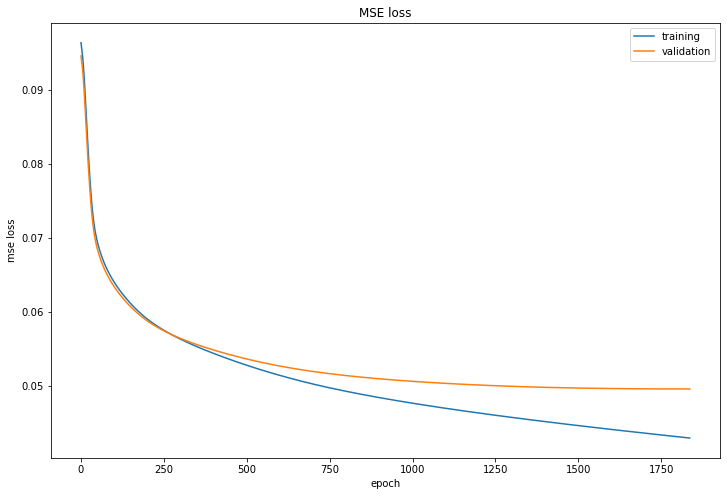

In [10]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [11]:
predictions = model.predict(testX)

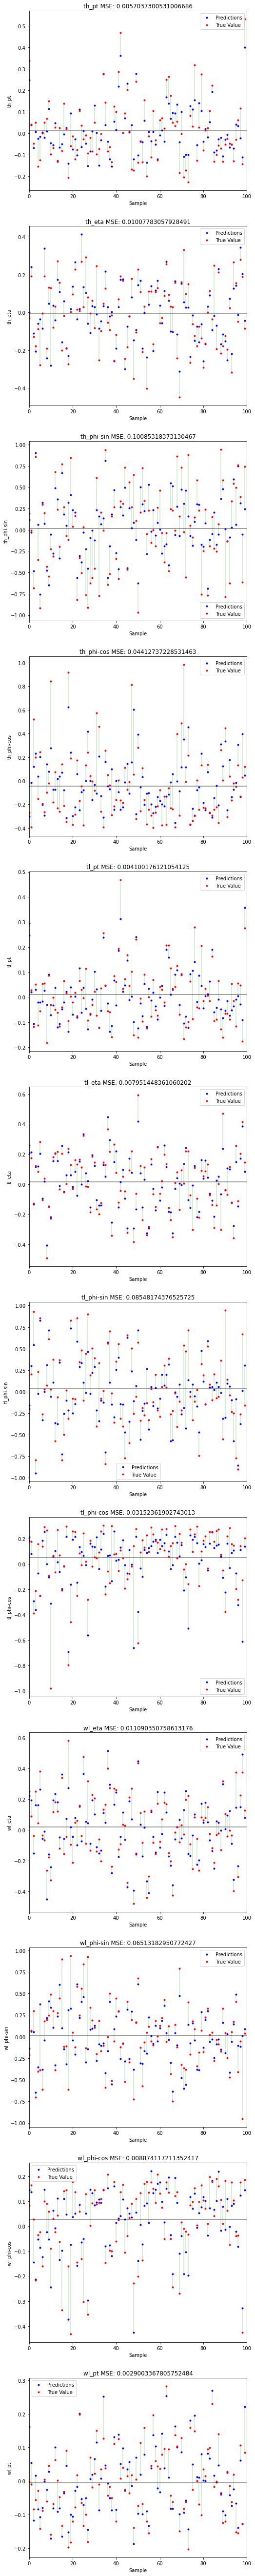

In [17]:

# Training 
crop = 100 

train_small = model.predict(trainX[0:100,:])
Y_small = trainY[0:100,:]


def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*len(Y_names)))
    for i in range(0,len(Y_names)):
        plt.subplot(len(Y_names),1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Sample')
        plt.ylabel(Y_names[i])
        plt.xlim(0, crop)
        plt.title(Y_names[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, Y_small)

In [18]:
# Predictions

predictions_small = predictions[0:100,:]
testY_small = testY[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- testY)**2)
print("total MSE: " + str(MSE))

for i in range(Y_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -testY[:,i])**2)
    print("{0} MSE : ".format(Y_names[i]), '%.10f'%MSE)

total MSE: 0.045397487370794534
th_pt MSE :  0.0073832529
th_eta MSE :  0.0128988760
th_phi-sin MSE :  0.1727023873
th_phi-cos MSE :  0.0740119883
tl_pt MSE :  0.0047981265
tl_eta MSE :  0.0106651990
tl_phi-sin MSE :  0.1287218574
tl_phi-cos MSE :  0.0442590303
wl_eta MSE :  0.0094709863


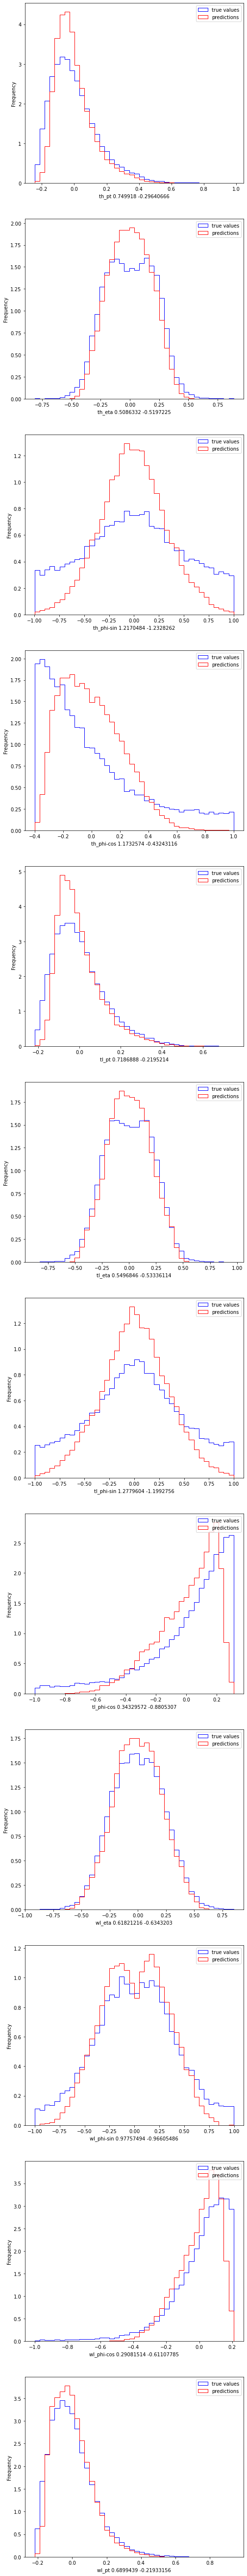

In [19]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*len(Y_names)))
for i in range(len(Y_names)):
    plt.subplot(len(Y_names), 1, i+1)
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(testY[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(Y_names[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

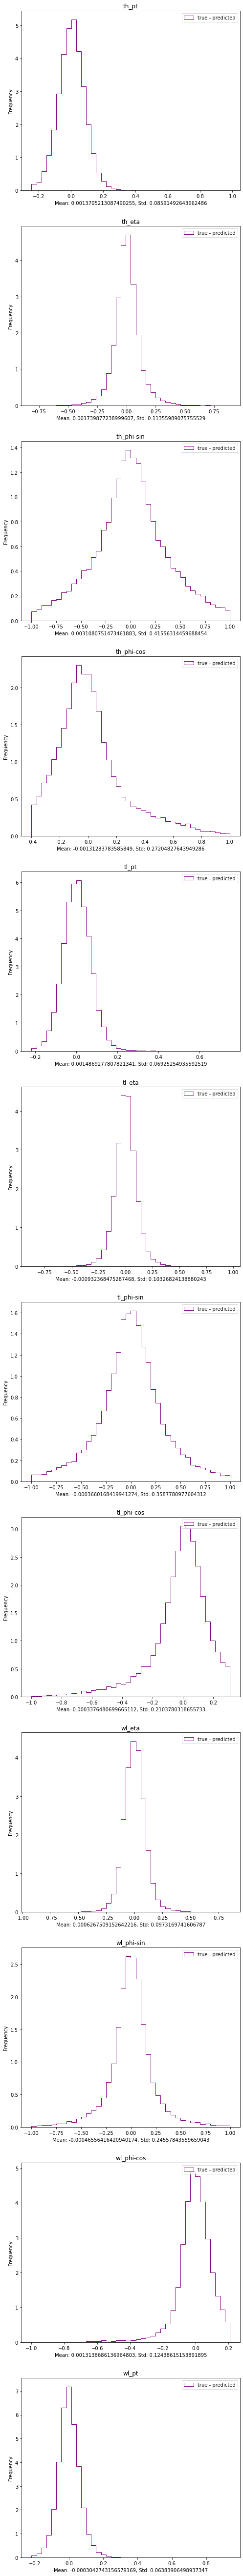

In [20]:
# True - Predicted 

plt.figure(figsize=(8,8*len(Y_names)))
for i in range(len(Y_names)):
    plt.subplot(len(Y_names), 1, i+1)
    diff = testY[:,i] - predictions[:,i]
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_names[i])
    plt.legend()
    plt.ylabel('Frequency')

In [21]:
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)
out_scaled = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

total_predictions = model.predict(X_total)
predict_scaled = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]

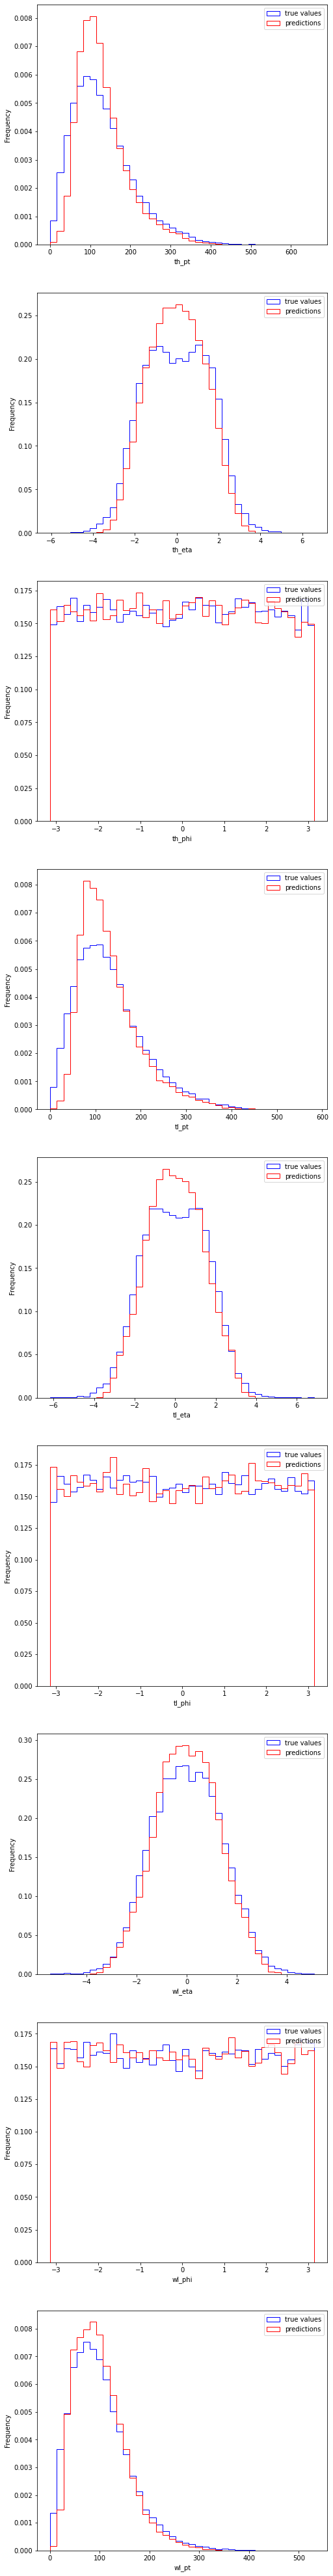

In [22]:
# Histograms to the original scale 

plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    hist, edges = np.histogram(out_scaled[:, i], 40)
    plt.hist(out_scaled[:, i], edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

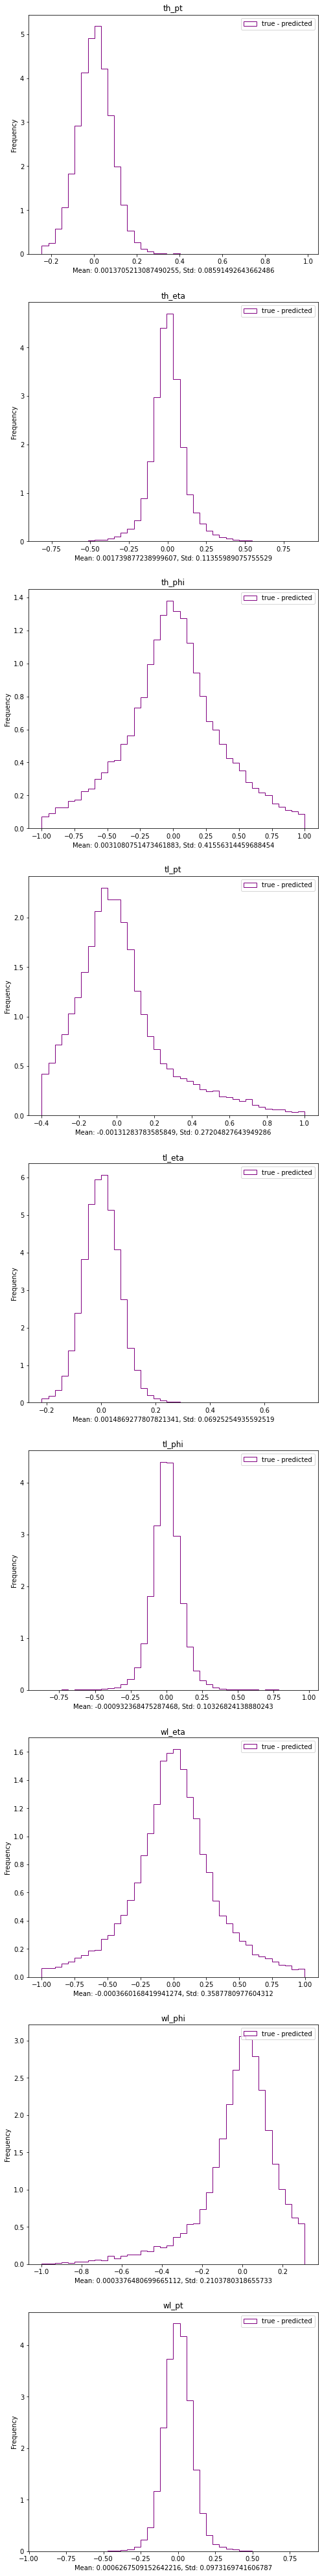

In [23]:
# True - Predicted 

plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    diff = testY[:,i] - predictions[:,i]
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

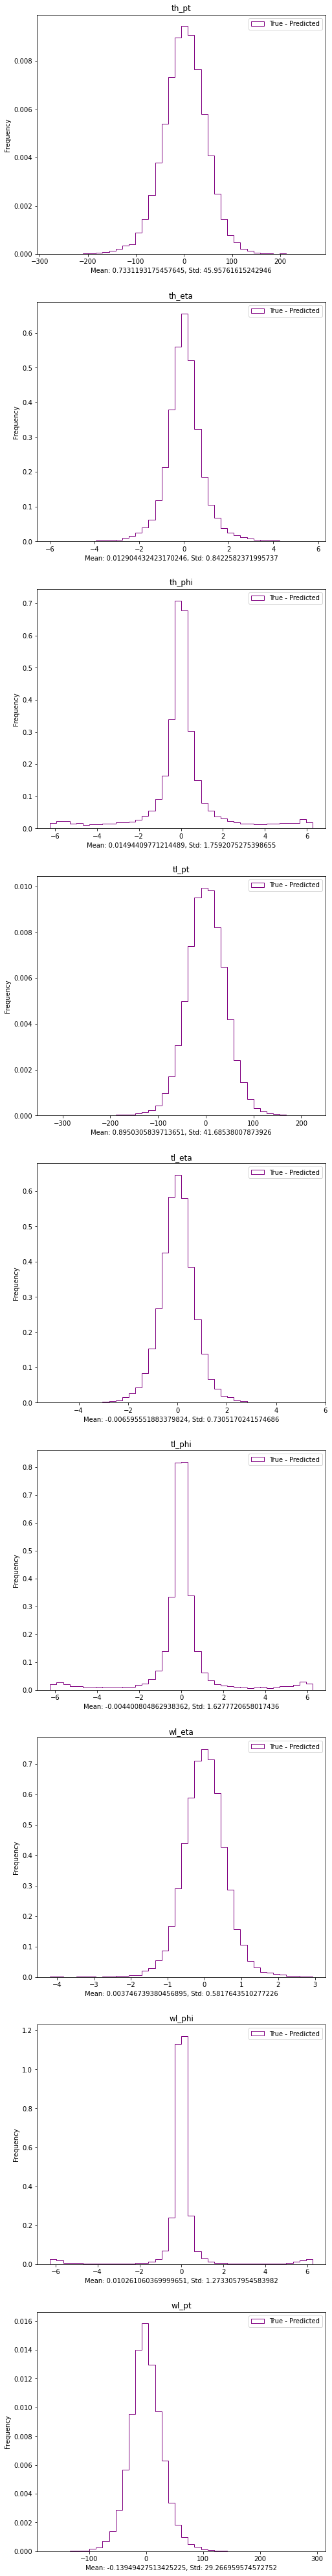

In [24]:
# Difference value histograms 
plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    diff = -predict_scaled[:, i]+out_scaled[:, i]
    plt.hist(diff, 40, histtype='step', color='purple', label='True - Predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [25]:
for i in range(Y_length):
    if Y_keys[i].split("_")[1] == 'phi':
        mod_pi = (predict_scaled[:,i] - out_scaled[:,i]) % (2*np.pi)
        mod_pi = mod_pi - 2*np.pi*(mod_pi > np.pi)
        MSE = 1/predict_scaled[:,i].size*np.sum((mod_pi)**2)
    else:
        MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] - out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(Y_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  2112.6399463478
Original Scale th_eta MSE :  0.7095654625
Original Scale th_phi MSE :  0.9244040217
Original Scale tl_pt MSE :  1738.4719920552
Original Scale tl_eta MSE :  0.5336986239
Original Scale tl_phi MSE :  0.6013825586
Original Scale wl_eta MSE :  0.3384637982
Original Scale wl_phi MSE :  0.2243372796
Original Scale wl_pt MSE :  856.5743813925


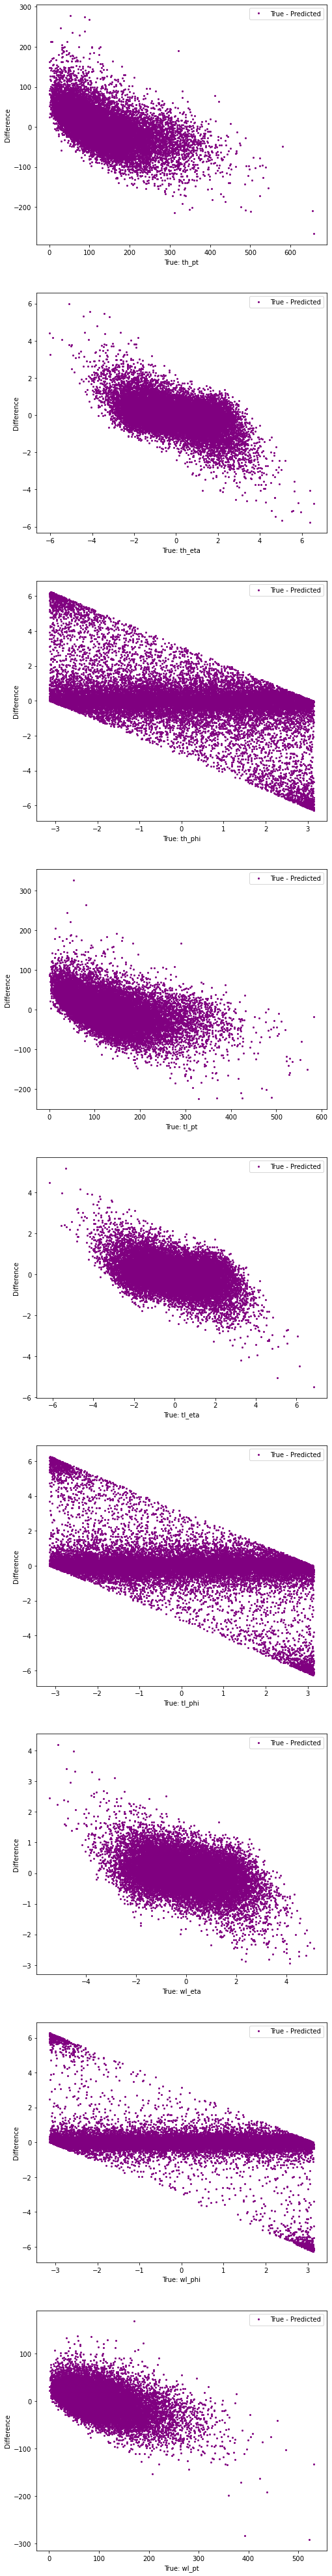

In [26]:
plt.figure(figsize=(8,8*Y_length))
for i in range(Y_length):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.plot(out_scaled[:, i], predict_scaled[:, i]-out_scaled[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
    plt.xlabel('True: ' + Y_keys[i])
    plt.legend()
    plt.ylabel('Difference')